<a href="https://colab.research.google.com/github/mm6396/ClusterComp/blob/main/evaluation_modulus8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Imports Section**


***New Expremiments; ***

In [1]:
#-------------------------------------------------------------------------------
#Method for Preprocessing datasetsand replacing nulls :
#-------------------------------------------------------------------------------

import pandas as pd
import os

def processing_procedure(files):
    processed_files = []
    for filename in files:

        df = pd.read_excel(filename, engine='openpyxl')

        # Interpolate using the nearest method
        df.interpolate(method='nearest', inplace=True, limit_direction='both')
        
        # Fill remaining NaNs with the mean of the column
        df.fillna(df.mean(), inplace=True)

        processed_filename = filename.split('.')[0] + '_processed.' + filename.split('.')[1]

        if os.path.exists(processed_filename):
            print(f"{processed_filename} already exists. Overwriting...")

        # Save (or overwrite) the processed data into the new spreadsheet.
        df.to_excel(processed_filename, index=False)

        processed_files.append(processed_filename)

    return processed_files



In [2]:
#-------------------------------------------------------------------------------
#------------GENERAL KEMENY YOUNG METHOD----------------------------------------
#-------------------------------------------------------------------------------


import numpy as np
import scipy.sparse as sp
import itertools
import numpy as np
from __future__ import division
from timeit import default_timer as time
from cylp.cy import CyClpSimplex
from cylp.py.pivots import PositiveEdgePivot
import importlib
import itertools
import numpy as np
import scipy.sparse as sp
#from utils import combs, perms
#from fairlearn.reductions import extended_condorcet_simple

def extended_condorcet_simple(rankings):

    # assumes: cands -> 0,N-1
    n = rankings.shape[1]
    cands = np.arange(n)
    pairs = combs(range(n), 2)

    condorcet_rows, condorcet_cols = [], []

    for cand, other_cand in pairs:
        cand_pos = np.where(rankings == cand)[1]
        other_pos = np.where(rankings == other_cand)[1]

        if np.all(cand_pos < other_pos):
            condorcet_rows.append(cand)
            condorcet_cols.append(other_cand)
        elif np.all(other_pos < cand_pos):
            condorcet_rows.append(other_cand)
            condorcet_cols.append(cand)

    mat = sp.coo_matrix((np.ones(len(condorcet_rows)), (condorcet_rows, condorcet_cols)))
    return mat

def combs(a, r):
    """
    Return successive r-length combinations of elements in the array a.
    Should produce the same output as array(list(combinations(a, r))), but
    faster.
    """
    a = np.asarray(a)
    dt = np.dtype([('', a.dtype)]*r)
    b = np.fromiter(itertools.combinations(a, r), dt)
    b_ = b.view(a.dtype).reshape(-1, r)
    return b_

def perms(a, r):
    """
    Same as above with permutations
    """
    a = np.asarray(a)
    dt = np.dtype([('', a.dtype)]*r)
    b = np.fromiter(itertools.permutations(a, r), dt)
    b_ = b.view(a.dtype).reshape(-1, r)
    return b_

class KemenyRanking():
    def __init__(self, fp, verbose=True, condorcet_red=True):
        self.verbose = verbose
        self.condorcet_red = True
        self.parse_file(fp)
        self.build_Q()
        self.solve_ilp()
        self.postprocess()
        self.get_solution()

    def parse_file(self, fp):
        """ Reads and preprocesses input """
        # TODO add checks
        # TODO add specification
        if self.verbose:
            print('Parse input')

        with open(fp) as file:
            content = file.readlines()
            content = [x.strip() for x in content]                          # remove newlines
            content = [x.replace(':', '') for x in content]                 # remove ":"
            content = [np.array(x.split(), dtype=object) for x in content]  # split line into list
                                                                            # -> array

            raw_arr = np.array(content)
            self.voters_raw = raw_arr[:, 0]
            self.votes_raw = raw_arr[:, 1:]

            # Map to 0, N -> only votes!
            self.orig2id = {}
            self.id2orig = {}
            id_ = 0
            for i in np.unique(self.votes_raw):
                self.orig2id[i] = id_
                self.id2orig[id_] = i
                id_ += 1
            self.votes_arr = np.vectorize(self.orig2id.get)(self.votes_raw)

        if self.verbose:
            print('     ... finished')

            print('Problem statistics')
            print('  {} votes'.format(self.votes_arr.shape[0]))
            print('  {} candidates'.format(self.votes_arr.shape[1]))

    def build_Q(self):
        """ Creates incidence-matrix: form used in MIP-model """
        if self.verbose:
            print('Build incidence-matrix')

        N, n = self.votes_arr.shape                                              # N votes, n cands
        self.Q = np.zeros((n,n))
        for a,b in itertools.combinations(range(n), 2):
            a_pos = np.where(self.votes_arr == a)[1]
            b_pos = np.where(self.votes_arr == b)[1]
            plus = np.count_nonzero(a_pos < b_pos)
            minus = np.count_nonzero(a_pos > b_pos)
            self.Q[a,b] = plus
            self.Q[b,a] = minus

        if self.verbose:
            print('     ... finished')

    def solve_ilp(self):
        """ Solves problem exactly using MIP/ILP approach
            Used solver: CoinOR CBC
            Incidence-matrix Q holds complete information needed for opt-process
        """
        if self.verbose:
            print('Solve: build model')

        if self.condorcet_red:
            condorcet_red_mat = extended_condorcet_simple(self.votes_arr)

        n = self.Q.shape[0]
        x_n = n*n

        model = CyClpSimplex()                                           # MODEL
        x = model.addVariable('x', x_n, isInt=True)                      # VARS

        model.objective = self.Q.ravel()                                 # OBJ

        # x_ab = boolean (already int; need to constrain to [0,1])
        model += sp.eye(x_n) * x >= np.zeros(x_n)
        model += sp.eye(x_n) * x <= np.ones(x_n)

        idx = lambda i, j: np.ravel_multi_index((i, j), (n,n))

        # constraints for every pair
        start_time = time()
        n_pairwise_constr = n*(n-1)//2
        if self.verbose:
            print('  # pairwise constr: ', n_pairwise_constr)

        # Somewhat bloated just to get some vectorization / speed !
        combs_ = combs(range(n), 2)

        inds_a = np.ravel_multi_index(combs_.T, (n, n))
        inds_b = np.ravel_multi_index(combs_.T[::-1], (n, n))

        row_inds = np.tile(np.arange(n_pairwise_constr), 2)
        col_inds = np.hstack((inds_a, inds_b))

        pairwise_constraints = sp.coo_matrix((np.ones(n_pairwise_constr*2),
                                              (row_inds, col_inds)),
                                              shape=(n_pairwise_constr, n*n))
        end_time = time()
        if self.verbose:
            print("    Took {:.{prec}f} secs".format(end_time - start_time, prec=3))

        # and for every cycle of length 3
        start_time = time()
        n_triangle_constrs = n*(n-1)*(n-2)
        if self.verbose:
            print('  # triangle constr: ', n_triangle_constrs)

        # Somewhat bloated just to get some vectorization / speed !
        perms_ = perms(range(n), 3)

        inds_a = np.ravel_multi_index(perms_.T[(0,1), :], (n, n))
        inds_b = np.ravel_multi_index(perms_.T[(1,2), :], (n, n))
        inds_c = np.ravel_multi_index(perms_.T[(2,0), :], (n, n))

        row_inds = np.tile(np.arange(n_triangle_constrs), 3)
        col_inds = np.hstack((inds_a, inds_b, inds_c))

        triangle_constraints = sp.coo_matrix((np.ones(n_triangle_constrs*3),
                                              (row_inds, col_inds)),
                                              shape=(n_triangle_constrs, n*n))
        end_time = time()
        if self.verbose:
            print("    Took {:.{prec}f} secs".format(end_time - start_time, prec=3))


        model += pairwise_constraints * x == np.ones(n_pairwise_constr)
        model += triangle_constraints * x >= np.ones(n_triangle_constrs)

        if self.condorcet_red:
            I, J, V = sp.find(condorcet_red_mat)
            indices_pos = np.ravel_multi_index([J, I], (n,n))
            indices_neg = np.ravel_multi_index([I, J], (n,n))
            nnz = len(indices_pos)

            if self.verbose:
                print('  Extended Condorcet reductions: {} * 2 relations fixed'.format(nnz))

            lhs = sp.coo_matrix((np.ones(nnz*2),
                        (np.arange(nnz*2),
                         np.hstack((indices_pos, indices_neg)))),
                  shape=(nnz*2, n*n))
            rhs = np.hstack((np.ones(len(indices_pos)), np.zeros(len(indices_neg))))
            model += lhs * x == rhs

        cbcModel = model.getCbcModel()  # Clp -> Cbc model / LP -> MIP
        cbcModel.logLevel = self.verbose

        if self.verbose:
            print('Solve: run MIP\n')
        start_time = time()
        status = cbcModel.solve()           #-> "Call CbcMain. Solve the problem
                                            #   "using the same parameters used
                                            #   "by CbcSolver."
                                            # This deviates from cylp's docs which are sparse!
                                            # -> preprocessing will be used and is very important!
        end_time = time()
        if self.verbose:
            print("  CoinOR CBC used {:.{prec}f} secs".format(end_time - start_time, prec=3))

        x_sol = cbcModel.primalVariableSolution['x']
        self.obj_sol = cbcModel.objectiveValue
        x = np.array(x_sol).reshape((n, n)).round().astype(int)
        self.aggr_rank = np.argsort(x.sum(axis=0))[::-1]

    def postprocess(self):
        if self.verbose:
            print('Postprocessing')
        self.final_solution = np.vectorize(self.id2orig.get)(self.aggr_rank)
        if self.verbose:
            print('    ... finished')


    def  get_solution(self):
       return self.final_solution

   # def print_sol(self):
   #     print('--------')
   #     print('SOLUTION')
   #     print('  objective: ', self.obj_sol)
   #     print('  aggregation: ')
   #     print(self.final_solution)






# Please Run : KemenyRanking('/content/yourfile_name.txt')


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_3531/1940611784.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


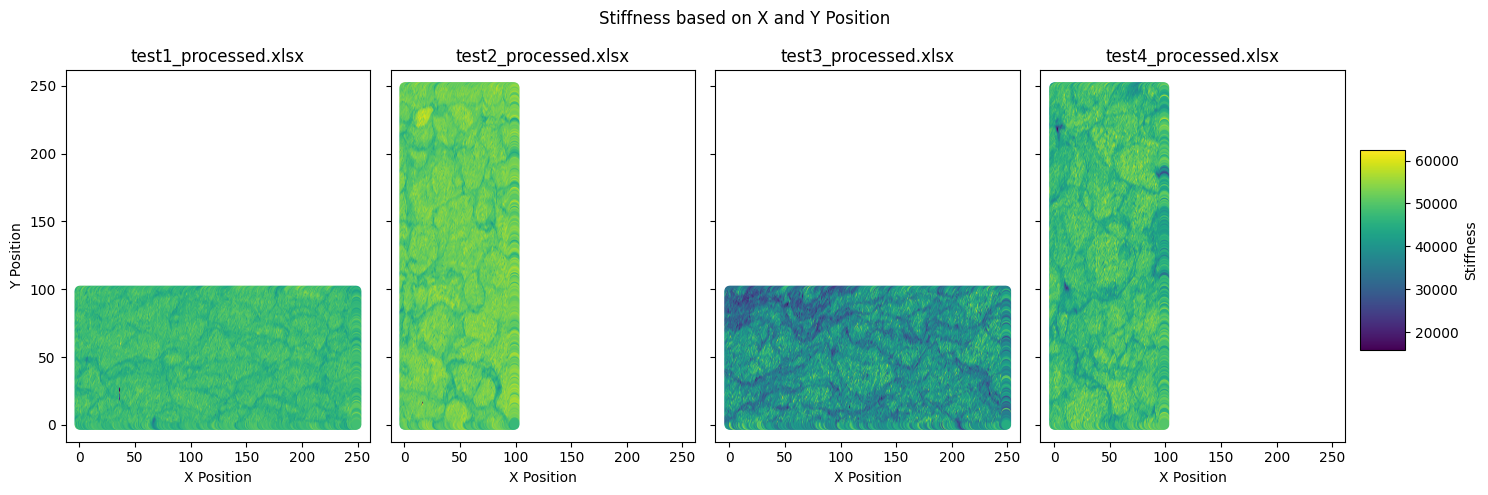

test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_3531/1940611784.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


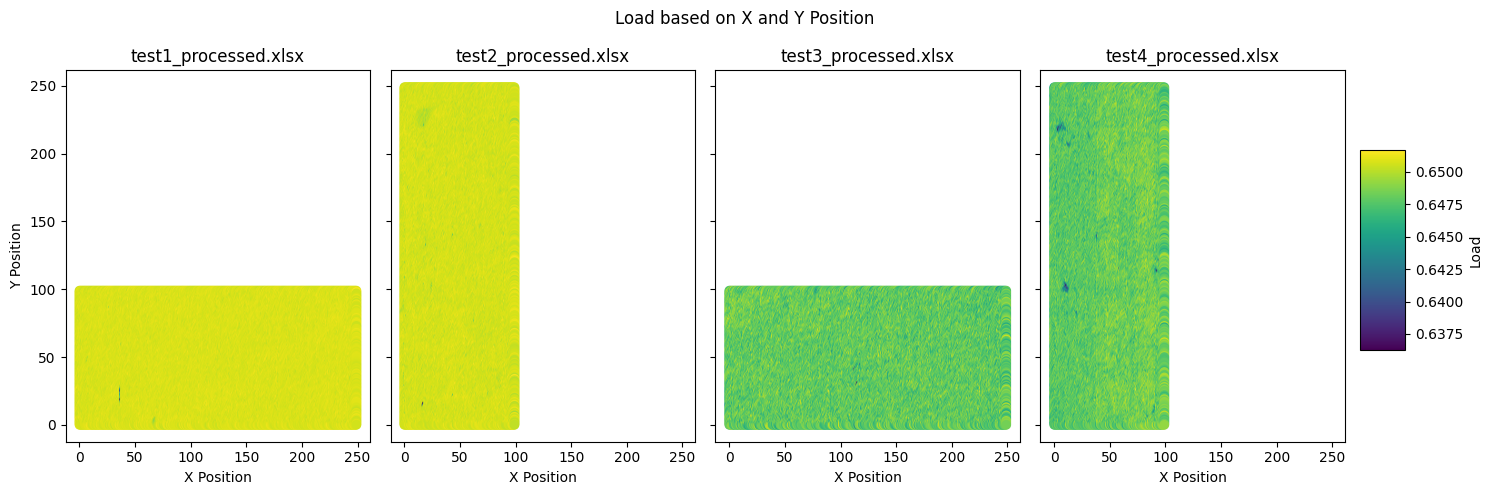

test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_3531/1940611784.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


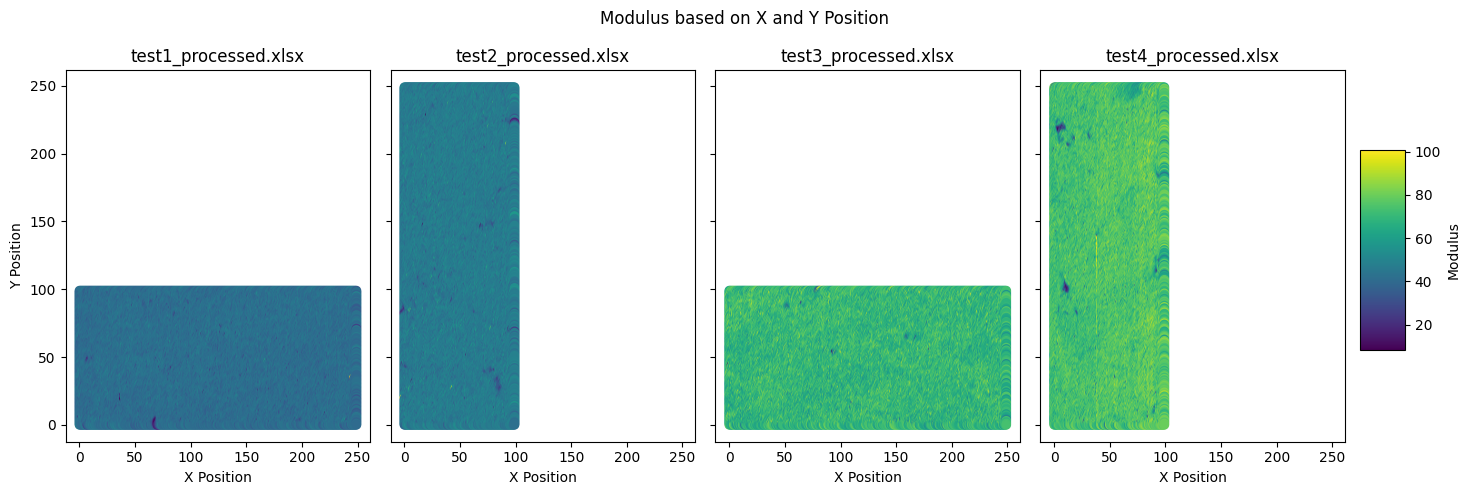

test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_3531/1940611784.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


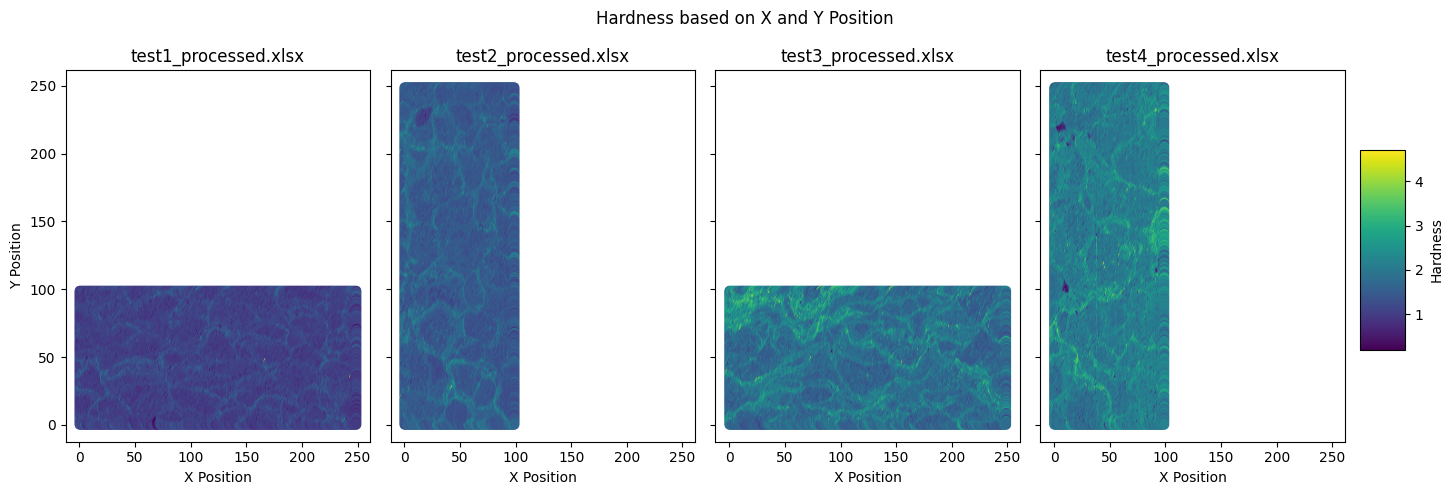

In [5]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Visulization Stifness based on X and Y positions
#-------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)

datasets = [pd.read_excel(file, engine='openpyxl') for file in files_p]

fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ax, df, file in zip(axs, datasets, files_p):
    sc = ax.scatter(df['X Position'], df['Y Position'], c=df['Stiffness'], cmap='viridis')
    ax.set_title(file)
    ax.set_xlabel('X Position')
    if ax == axs[0]:
        ax.set_ylabel('Y Position')

fig.colorbar(sc, cax=cbar_ax, label='Stiffness')
plt.suptitle('Stiffness based on X and Y Position')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()



#------------------------------------------------------------------------------
# visulization Load based on x and Y positions
#------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt


files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]

files_p = processing_procedure(files)



datasets = [pd.read_excel(file, engine='openpyxl') for file in files_p]


fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ax, df, file in zip(axs, datasets, files_p):
    sc = ax.scatter(df['X Position'], df['Y Position'], c=df['Load'], cmap='viridis')
    ax.set_title(file)
    ax.set_xlabel('X Position')
    if ax == axs[0]:
        ax.set_ylabel('Y Position')

fig.colorbar(sc, cax=cbar_ax, label='Load')

plt.suptitle('Load based on X and Y Position')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()



#-------------------------------------------------------------------------------
#Vitualization MODULUS based X and Y positions
#-------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt


files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)


datasets = [pd.read_excel(file, engine='openpyxl') for file in files_p]


fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ax, df, file in zip(axs, datasets, files_p):
    sc = ax.scatter(df['X Position'], df['Y Position'], c=df['MODULUS'], cmap='viridis')
    ax.set_title(file)
    ax.set_xlabel('X Position')
    if ax == axs[0]:
        ax.set_ylabel('Y Position')

fig.colorbar(sc, cax=cbar_ax, label='Modulus')

plt.suptitle('Modulus based on X and Y Position')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()


#-------------------------------------------------------------------------------
#Show HARDNESS based on X and Y positions
#-------------------------------------------------------------------------------


import pandas as pd
import matplotlib.pyplot as plt


files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)


datasets = [pd.read_excel(file, engine='openpyxl') for file in files_p]


fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ax, df, file in zip(axs, datasets, files_p):
    sc = ax.scatter(df['X Position'], df['Y Position'], c=df['HARDNESS'], cmap='viridis')
    ax.set_title(file)
    ax.set_xlabel('X Position')
    if ax == axs[0]:
        ax.set_ylabel('Y Position')

fig.colorbar(sc, cax=cbar_ax, label='Hardness')

plt.suptitle('Hardness based on X and Y Position')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

In [12]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Tuning parameters for "Agglomerative"
#-------------------------------------------------------------------------------

import os,csv
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

param_grid = {
    'n_clusters': [3],
    'affinity': ['euclidean', 'manhattan'],
    'linkage': ['ward', 'complete', 'average']
}

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)
for file in files_p:
    df = pd.read_excel(file, engine='openpyxl')
    print(f"NaN values in {file}:", df.isnull().sum().sum())
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label']

eval_files = []
tuning_files = []

# Mapping of files to the position we're interested in
position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}
for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]


    eval_filename = f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

    # tuning
    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]


    tuning_filename = f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)




results = []
max_silhouette = -1
best_params = {}

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')



    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_clusters in param_grid['n_clusters']:
        for affinity in param_grid['affinity']:
            for linkage in param_grid['linkage']:
                # 'ward' can only work with 'euclidean'
                if linkage == 'ward' and affinity != 'euclidean':
                    continue

                model = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
                labels = model.fit_predict(scaled_eval)

                score = silhouette_score(scaled_eval, labels)

                # Append results to the list
                results.append({
                    'file': eval_filename,
                    'n_clusters': n_clusters,
                    'affinity': affinity,
                    'linkage': linkage,
                    'silhouette_score': score
                })



df_results = pd.DataFrame(results)

def concat_parameters(group):
    # This will force even single items into a comma-separated string format

    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:4].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:4], axis=1)
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
df_results['rank'] = df_results.groupby('file')['silhouette_score'].rank(method='first', ascending=False).astype(int)

grouped_combinations = df_results.groupby(['file']).apply(concat_parameters)

output_file = "Agglomerative+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


with open('tuning_list_kemeny_agglomerative.txt', 'w') as f:
    i = 1
    for _, group_string in grouped_combinations.items():
        f.write(f'A{i} : {group_string}\n')
        i += 1












test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...
NaN values in test1_processed.xlsx: 0
NaN values in test2_processed.xlsx: 25000
NaN values in test3_processed.xlsx: 0
NaN values in test4_processed.xlsx: 0


In [3]:
#To run the KemenyRanking and get the solution:
# kemeny = KemenyRanking('/content/yourfile_name.txt')
# ranked_list = kemeny.get_solution()
# print(ranked_list)

solution_array = KemenyRanking('tuning_list_kemeny_agglomerative.txt').get_solution()

print(solution_array)



Parse input
     ... finished
Problem statistics
  4 votes
  5 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  10
    Took 0.000 secs
  # triangle constr:  60
    Took 0.000 secs
  Extended Condorcet reductions: 7 * 2 relations fixed
Solve: run MIP

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

  CoinOR CBC used 0.020 secs
command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 4 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 4 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active aft

In [16]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Tuning parameters for KMeans
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

param_grid_KMeans = {
    'n_clusters': [3],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [100, 200, 300],
    'random_state': [0, 42]
}

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)

columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label']

eval_files = []
tuning_files = []


position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)



    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

results = []
max_silhouette = -1
best_params = {}

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')

    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_clusters in param_grid_KMeans['n_clusters']:
        for init in param_grid_KMeans['init']:
            for n_init in param_grid_KMeans['n_init']:
                for max_iter in param_grid_KMeans['max_iter']:
                    for random_state in param_grid_KMeans['random_state']:
                        # KMeans clustering
                        model = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, random_state=random_state)
                        labels = model.fit_predict(scaled_eval)

                        score = silhouette_score(scaled_eval, labels)

                        # Append results to the list
                        results.append({
                            'file': eval_filename,
                            'n_clusters': n_clusters,
                            'init': init,
                            'n_init': n_init,
                            'max_iter': max_iter,
                            'random_state': random_state,
                            'silhouette_score': score
                        })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    # This will force even single items into a comma-separated string format

    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:6].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:6], axis=1)
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
df_results['rank'] = df_results.groupby('file')['silhouette_score'].rank(method='first', ascending=False).astype(int)

grouped_combinations = df_results.groupby(['file']).apply(concat_parameters)

output_file = "Kmeans+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


with open('tuning_list_Kemeny_kmeans.txt', 'w') as f:
    i = 1
    for _, group_string in grouped_combinations.items():
        f.write(f'A{i} : {group_string}\n')
        i += 1


test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


In [17]:
print(KemenyRanking('tuning_list_Kemeny_kmeans.txt').get_solution())

Parse input
     ... finished
Problem statistics
  4 votes
  36 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  630
    Took 0.000 secs
  # triangle constr:  42840
    Took 0.010 secs
  Extended Condorcet reductions: 45 * 2 relations fixed
Solve: run MIP

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
  CoinOR CBC used 0.247 secs
Postprocessing
    ... finished
['"3,k-means++,20,100,0"' '"3,k-means++,30,100,0"'
 '"3,k-means++,30,300,0"' '"3,k-means++,30,200,0"'
 '"3,k-means++,20,200,0"' '"3,k-means++,10,100,0"'
 '"3,k-means++,10,300,0"' '"3,k-means++,20,300,0"'
 '"3,k-means++,10,200,0"' '"3,k-means++,10,100,42"' '"3,random,10,300,42"'
 '"3,random,10,100,42"' '"3,k-means++,20,100,42"'
 '"3,k-means++,30,200,42"' '"3,k-means++,30,300,42"'
 '"3,k-means++,20,200,42"' '"3,k-means++,20,300,42"'
 '"3,k-means++,30,100,42"' '"3,k-means++,10,200,42"'
 '"3,k-means++,1

In [19]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Tuning parameters for DBSCAN
#-------------------------------------------------------------------------------
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN  # Import DBSCAN
from sklearn.metrics import silhouette_score

param_grid_DBSCAN = {
    'eps': [0.1, 0.2, 0.3],
    'min_samples': [5, 10, 15]
}

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)

columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness', 'label']

eval_files = []
tuning_files = []


position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)



    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

results = []
max_silhouette = -1
best_params = {}

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')

    scaled_eval = StandardScaler().fit_transform(eval_df)

    for eps in param_grid_DBSCAN['eps']:
        for min_samples in param_grid_DBSCAN['min_samples']:
            # DBSCAN clustering
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(scaled_eval)

            # DBSCAN can produce -1 labels for noise, so we need to filter them out for silhouette score
            core_samples_mask = labels != -1
            labels_core = labels[core_samples_mask]
            scaled_eval_core = scaled_eval[core_samples_mask]

            # Silhouette score is only meaningful if there's more than one cluster found
            if len(set(labels_core)) > 1:
                score = silhouette_score(scaled_eval_core, labels_core)
            else:
                score = -1

            # Append results to the list
            results.append({
                'file': eval_filename,
                'eps': eps,
                'min_samples': min_samples,
                'silhouette_score': score
            })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    # This will force even single items into a comma-separated string format

    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:3].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:3], axis=1)
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
df_results['rank'] = df_results.groupby('file')['silhouette_score'].rank(method='first', ascending=False).astype(int)

grouped_combinations = df_results.groupby(['file']).apply(concat_parameters)

output_file = "DBSCAN+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


with open('tuning_list_Kemeny_DBSCAN.txt', 'w') as f:
    i = 1
    for _, group_string in grouped_combinations.items():
        f.write(f'A{i} : {group_string}\n')
        i += 1



test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


In [20]:
print(KemenyRanking('tuning_list_Kemeny_DBSCAN.txt').get_solution())

Parse input
     ... finished
Problem statistics
  4 votes
  9 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  36
    Took 0.000 secs
  # triangle constr:  504
    Took 0.000 secs
  Extended Condorcet reductions: 3 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.007 secs
Postprocessing
    ... finished
['"0.2,10.0"' '"0.2,15.0"' '"0.3,10.0"' '"0.3,5.0"' '"0.2,5.0"'
 '"0.1,15.0"' '"0.1,10.0"' '"0.1,5.0"' '"0.3,15.0"']
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 40 - 0.00 seconds
Cgl0004I processed model has 147 rows, 33 columns (33 integer (33 of which binary)) and 426 elements
Cbc0012I Integer solution of 40 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 40, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on r

In [21]:

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Tuning parameters for FCM
#-------------------------------------------------------------------------------


import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM
from sklearn.metrics import silhouette_score

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)

# Columns to be excluded
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label']

eval_files = []
tuning_files = []


position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)



    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

# Define hyperparameters to search
n_clusters_values = [3]
m_values = [1.1, 1.5, 2.0]

results = []
best_score = -1
best_params = None

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_data = StandardScaler().fit_transform(eval_df)

    for n_clusters in n_clusters_values:
        for m in m_values:
            fcm = FCM(n_clusters=n_clusters, m=m)
            fcm.fit(scaled_data)
            cluster_labels = fcm.predict(scaled_data)

            score = silhouette_score(scaled_data, cluster_labels)

            results.append({
                'file': eval_filename,
                'n_clusters': n_clusters,
                'm': m,
                'silhouette_score': score
            })


df_results = pd.DataFrame(results)

def concat_parameters(group):
    # This will force even single items into a comma-separated string format

    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:3].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:3], axis=1)
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
df_results['rank'] = df_results.groupby('file')['silhouette_score'].rank(method='first', ascending=False).astype(int)

grouped_combinations = df_results.groupby(['file']).apply(concat_parameters)

output_file = "FCM+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


with open('tuning_list_Kemeny_FCM.txt', 'w') as f:
    i = 1
    for _, group_string in grouped_combinations.items():
        f.write(f'A{i} : {group_string}\n')
        i += 1


test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


In [22]:
print(KemenyRanking('tuning_list_Kemeny_FCM.txt').get_solution())

Parse input
     ... finished
Problem statistics
  4 votes
  3 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  3
    Took 0.000 secs
  # triangle constr:  6
    Took 0.000 secs
  Extended Condorcet reductions: 2 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.002 secs
Postprocessing
    ... finished
['"3.0,1.1"' '"3.0,1.5"' '"3.0,2.0"']
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 1 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 1 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knap

In [23]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Tuning parameters for GMM
#-------------------------------------------------------------------------------




import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)

# Columns to be excluded
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' ,'label']

eval_files = []
tuning_files = []


position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)



    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

# GMM parameters
param_grid_GMM = {
    'n_components': [3],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'max_iter': [100, 200, 300],
    'random_state': [0, 42]
}

results = []
max_silhouette = -1
best_params = {}

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_components in param_grid_GMM['n_components']:
        for covariance_type in param_grid_GMM['covariance_type']:
            for max_iter in param_grid_GMM['max_iter']:
                for random_state in param_grid_GMM['random_state']:
                    # GMM clustering
                    model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, max_iter=max_iter, random_state=random_state)
                    labels = model.fit_predict(scaled_eval)

                    score = silhouette_score(scaled_eval, labels)

                    # Append results to the list
                    results.append({
                        'file': eval_filename,
                        'n_components': n_components,
                        'covariance_type': covariance_type,
                        'max_iter': max_iter,
                        'random_state': random_state,
                        'silhouette_score': score
                    })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    # This will force even single items into a comma-separated string format

    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:5].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:5], axis=1)
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
df_results['rank'] = df_results.groupby('file')['silhouette_score'].rank(method='first', ascending=False).astype(int)

grouped_combinations = df_results.groupby(['file']).apply(concat_parameters)

output_file = "GMM+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


with open('tuning_list_Kemeny_GMM.txt', 'w') as f:
    i = 1
    for _, group_string in grouped_combinations.items():
        f.write(f'A{i} : {group_string}\n')
        i += 1


test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


In [24]:
print(KemenyRanking('tuning_list_Kemeny_GMM.txt').get_solution())

Parse input
     ... finished
Problem statistics
  4 votes
  24 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  276
    Took 0.000 secs
  # triangle constr:  12144
    Took 0.001 secs
  Extended Condorcet reductions: 112 * 2 relations fixed
Solve: run MIP

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
  CoinOR CBC used 0.054 secs
Postprocessing
    ... finished
['"3,tied,100,0"' '"3,tied,200,0"' '"3,tied,200,42"' '"3,tied,100,42"'
 '"3,tied,300,0"' '"3,tied,300,42"' '"3,spherical,100,0"'
 '"3,spherical,200,0"' '"3,spherical,300,0"' '"3,spherical,100,42"'
 '"3,spherical,200,42"' '"3,spherical,300,42"' '"3,diag,200,0"'
 '"3,diag,100,0"' '"3,diag,300,0"' '"3,diag,300,42"' '"3,diag,200,42"'
 '"3,diag,100,42"' '"3,full,300,42"' '"3,full,200,42"' '"3,full,100,42"'
 '"3,full,100,0"' '"3,full,300,0"' '"3,full,200,0"']
Continuous objective value is 179 - 0.01 seco

In [25]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Tuning parameters for Kmedoids
#-------------------------------------------------------------------------------



import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)

# Columns to be excluded
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness','label']

eval_files = []
tuning_files = []


position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)



    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

# KMedoids parameters
param_grid_KMedoids = {
    'n_clusters': [3],
    'init': ['random'],
    'max_iter': [100, 200],
    'random_state': [0, 42 ]
}

results = []
max_silhouette = -1
best_params = {}

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_clusters in param_grid_KMedoids['n_clusters']:
        for init in param_grid_KMedoids['init']:
            for max_iter in param_grid_KMedoids['max_iter']:
                for random_state in param_grid_KMedoids['random_state']:
                    # KMedoids clustering
                    model = KMedoids(n_clusters=n_clusters, init=init, max_iter=max_iter, random_state=random_state)
                    model.fit(scaled_eval)
                    labels = model.labels_

                    score = silhouette_score(scaled_eval, labels)

                    # Append results to the list
                    results.append({
                        'file': eval_filename,
                        'n_clusters': n_clusters,
                        'init': init,
                        'max_iter': max_iter,
                        'random_state': random_state,
                        'silhouette_score': score
                    })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    # This will force even single items into a comma-separated string format

    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:5].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:5], axis=1)
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
df_results['rank'] = df_results.groupby('file')['silhouette_score'].rank(method='first', ascending=False).astype(int)

grouped_combinations = df_results.groupby(['file']).apply(concat_parameters)

output_file = "Kmedoids+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


with open('tuning_list_Kemeny_Kmedoids.txt', 'w') as f:
    i = 1
    for _, group_string in grouped_combinations.items():
        f.write(f'A{i} : {group_string}\n')
        i += 1

test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


In [27]:
print(KemenyRanking('tuning_list_Kemeny_Kmedoids.txt').get_solution())

Parse input
     ... finished
Problem statistics
  4 votes
  4 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  6
    Took 0.000 secs
  # triangle constr:  24
    Took 0.000 secs
  Extended Condorcet reductions: 3 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.003 secs
Postprocessing
    ... finished
['"3,random,100,42"' '"3,random,200,42"' '"3,random,100,0"'
 '"3,random,200,0"']
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 3 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 3 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active afte

In [ ]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Tuning parameters for OPTICS
#-------------------------------------------------------------------------------
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)

# Columns to be excluded
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness', 'label']

eval_files = []
tuning_files = []


position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)



    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

# OPTICS parameters
param_grid_OPTICS = {
    'min_samples': [3 ,5],
    'xi': [0.05, 0.1, 0.2]
}

results = []
max_silhouette = -1
best_params = {}

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for min_samples in param_grid_OPTICS['min_samples']:
        for xi in param_grid_OPTICS['xi']:
            # OPTICS clustering
            model = OPTICS(min_samples=min_samples, xi=xi)
            model.fit(scaled_eval)


            if len(set(model.labels_)) <= 1 or (len(set(model.labels_)) == 2 and -1 in model.labels_):
               continue

            labels = model.labels_
            score = silhouette_score(scaled_eval, labels)

            # Append results to the list
            results.append({
                'file': eval_filename,
                'min_samples': min_samples,
                'xi': xi,
                'silhouette_score': score
            })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    # This will force even single items into a comma-separated string format

    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:3].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:3], axis=1)
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
df_results['rank'] = df_results.groupby('file')['silhouette_score'].rank(method='first', ascending=False).astype(int)

grouped_combinations = df_results.groupby(['file']).apply(concat_parameters)

output_file = "OPTICS+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


with open('tuning_list_Kemeny_OPTICS.txt', 'w') as f:
    i = 1
    for _, group_string in grouped_combinations.items():
        f.write(f'A{i} : {group_string}\n')
        i += 1


test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [29]:
print(KemenyRanking('tuning_list_Kemeny_OPTICS.txt').get_solution())

Parse input
     ... finished
Problem statistics
  4 votes
  6 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  15
    Took 0.000 secs
  # triangle constr:  120
    Took 0.000 secs
  Extended Condorcet reductions: 15 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.003 secs
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

Postprocessing
    ... finished
['"3.0,0.05"' '"3.0,0.1"' '"5.0,0.05"' '"3.0,0.2"' '"5.0,0.1"' '"5.0,0.2"']
command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after 

In [30]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Tuning parameters for BIRCH
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

files = ["test1.xlsx", "test2.xlsx", "test3.xlsx", "test4.xlsx"]
files_p = processing_procedure(files)


columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' ,'label']

eval_files = []
tuning_files = []


position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)



    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

# BIRCH parameters
param_grid_BIRCH = {
    'n_clusters': [3],
    'threshold': [0.1, 0.2 , 0.5],
    'branching_factor': [100 , 200]
}

results = []
max_silhouette = -1
best_params = {}

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_clusters in param_grid_BIRCH['n_clusters']:
        for threshold in param_grid_BIRCH['threshold']:
            for branching_factor in param_grid_BIRCH['branching_factor']:
                # BIRCH clustering
                model = Birch(n_clusters=n_clusters, threshold=threshold, branching_factor=branching_factor)
                model.fit(scaled_eval)
                labels = model.labels_

                score = silhouette_score(scaled_eval, labels)

                # Append results to the list
                results.append({
                    'file': eval_filename,
                    'n_clusters': n_clusters,
                    'threshold': threshold,
                    'branching_factor': branching_factor,
                    'silhouette_score': score
                })
df_results = pd.DataFrame(results)

def concat_parameters(group):
    # This will force even single items into a comma-separated string format

    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:4].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:4], axis=1)
df_results = df_results.sort_values(by='silhouette_score', ascending=False)
df_results['rank'] = df_results.groupby('file')['silhouette_score'].rank(method='first', ascending=False).astype(int)

grouped_combinations = df_results.groupby(['file']).apply(concat_parameters)

output_file = "BIRCH+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


with open('tuning_list_Kemeny_BIRCH.txt', 'w') as f:
    i = 1
    for _, group_string in grouped_combinations.items():
        f.write(f'A{i} : {group_string}\n')
        i += 1


test1_processed.xlsx already exists. Overwriting...
test2_processed.xlsx already exists. Overwriting...
test3_processed.xlsx already exists. Overwriting...
test4_processed.xlsx already exists. Overwriting...


In [31]:
print(KemenyRanking('tuning_list_Kemeny_BIRCH.txt').get_solution())

Parse input
     ... finished
Problem statistics
  4 votes
  6 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  15
    Took 0.000 secs
  # triangle constr:  120
    Took 0.000 secs
  Extended Condorcet reductions: 4 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.003 secs
Postprocessing
    ... finished
['"3.0,0.1,200.0"' '"3.0,0.2,100.0"' '"3.0,0.2,200.0"' '"3.0,0.5,100.0"'
 '"3.0,0.5,200.0"' '"3.0,0.1,100.0"']
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 14 - 0.00 seconds
Cgl0004I processed model has 25 rows, 11 columns (11 integer (11 of which binary)) and 66 elements
Cbc0012I Integer solution of 14 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 14, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced c

Generating HMresults * in 4 steps

In [84]:
#-------------------------------------------------------------------------------
# *********************** generating HM-results ********************************
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, Birch
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


files_p = ["test_1_tuning.xlsx", "test_2_tuning.xlsx", "test_3_tuning.xlsx", "test_4_tuning.xlsx"]
#files_p = processing_procedure(files)
# EXCLUDE *******************************************************
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label'] # please exclude those features that you dont need them
                                                                                           #First we do the expriments with Hardness alone and then Modulus Alone and then The combination of them
datasets = [pd.read_excel(file, engine='openpyxl').drop(columns_to_drop, axis=1, errors='ignore') for file in files_p]
scaled_datasets = [StandardScaler().fit_transform(df) for df in datasets]

clustering_algorithms = {
    'KMeans': KMeans(n_clusters=3, random_state=0 , init= 'k-means++' , n_init = 20 , max_iter = 100 ),

    'DBSCAN': DBSCAN(eps=0.2 , min_samples = 10),
    'Agglomerative': AgglomerativeClustering(n_clusters=3 , affinity = 'euclidean' ,  linkage = 'average'),
                     #linkage = {'ward' (default) , 'complete' , 'average' , 'single'}
                     #affinity= {'euclidean' , 'manhattan , 'cosine'}
    'OPTICS': OPTICS(min_samples = 3 , xi = 0.05),
    'KMedoids': KMedoids(n_clusters=3, random_state= 0 , init = 'random' , max_iter = 100),
                     #metric = {c , 'precomputed'}
    'GMM': GaussianMixture(n_components=3, max_iter=100 , covariance_type = 'tied'),
    'BIRCH': Birch(n_clusters=3 , branching_factor = 200 , threshold =0.1),

    'FCM': FCM(n_clusters=3 , m = 1.1)
}


metrics = {
    'Silhouette': silhouette_score,
    'Calinski-Harabasz': calinski_harabasz_score,
    'Davies-Bouldin': davies_bouldin_score
}

results = []

for index, (scaled_data, file_name) in enumerate(zip(scaled_datasets, files_p)):
    dataset_label = 'D' + str(index + 1)
    for algorithm_name, algorithm in clustering_algorithms.items():

        if algorithm_name == 'GMM':
            cluster_labels = algorithm.fit_predict(scaled_data)
        elif algorithm_name == 'FCM':
            algorithm.fit(scaled_data)
            cluster_labels = algorithm.u.argmax(axis=1)
        else:
            cluster_labels = algorithm.fit_predict(scaled_data)

        if len(set(cluster_labels)) > 1:
            for metric_name, metric_func in metrics.items():
                score = metric_func(scaled_data, cluster_labels)
                results.append({'Metric': metric_name,
                                'Dataset': dataset_label,
                                'Method': algorithm_name,
                                'Score': score})

results_df = pd.DataFrame(results)

# Reset the index to add 'Metric' and 'Dataset' as columns instead of multi-index
grouped = results_df.groupby(['Metric', 'Dataset', 'Method']).Score.mean().reset_index().pivot(index=['Metric', 'Dataset'], columns='Method', values='Score')
# Reset the multi-index and then set 'Dataset' as the new index
grouped = grouped.reset_index().set_index('Dataset')

if os.path.exists("HMresults.xlsx"):
    os.remove("HMresults.xlsx")

grouped.to_excel("HMresults.xlsx")
print(grouped.to_latex())









\begin{tabular}{llrrrrrrrr}
\toprule
Method &             Metric &  Agglomerative &        BIRCH &      DBSCAN &          FCM &          GMM &       KMeans &     KMedoids &     OPTICS \\
Dataset &                    &                &              &             &              &              &              &              &            \\
\midrule
D1      &  Calinski-Harabasz &     302.707577 &  5299.272131 &  131.442817 &  9305.011781 &  4445.378165 &  9305.094046 &  8998.792221 &  10.638527 \\
D2      &  Calinski-Harabasz &     221.243332 &  5187.384063 &  147.515811 &  7160.731394 &  3522.860454 &  7161.550342 &  6942.557392 &  10.607323 \\
D3      &  Calinski-Harabasz &     200.386318 &  6119.087720 &  205.489622 &  9808.895882 &  6675.338893 &  9808.183334 &  9657.315998 &   9.878291 \\
D4      &  Calinski-Harabasz &    1603.223039 &  4971.937198 &  278.568459 &  7546.419932 &  3586.112348 &  7547.239494 &  6942.174425 &  11.623450 \\
D1      &     Davies-Bouldin &       0.372257 &  

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/1179693465.py:80: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(grouped.to_latex())


In [111]:
#------------------------------------------------------------------------
#----------------HM_result step (2) -------------------------------------
#------------------------------------------------------------------------
import pandas as pd


df = pd.read_excel("HMresults.xlsx", engine='openpyxl')


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Initialize an empty list to store rows and their corresponding rankings
interleaved_rows = []

for _, row in df.iterrows():
    # Append the original row first
    interleaved_rows.append(row)

    # Duplicate the row to assign rankings
    new_row = row.copy()
    new_row['Dataset'] = f"{row['Dataset']}_Ranking"

    # Depending on the metric, rank the clustering methods
    if row['Metric'] == 'Davies-Bouldin':
        rankings = row[clustering_methods].rank(ascending=True, method='first').astype(int)
    else:
        rankings = row[clustering_methods].rank(ascending=False, method='first').astype(int)

    new_row[clustering_methods] = rankings
    interleaved_rows.append(new_row)

# Convert the interleaved rows to a dataframe
rankings_df = pd.DataFrame(interleaved_rows)

# Save the updated results file
rankings_df.to_excel("HMresults2.xlsx", index=False)



df = pd.read_excel("HMresults2.xlsx")

# Convert the DataFrame to LaTeX format
latex_code = df.to_latex()

# Print the LaTeX code
print(latex_code)



\begin{tabular}{lllrrrrrrrr}
\toprule
{} &     Dataset &             Metric &  Agglomerative &        BIRCH &      DBSCAN &          FCM &          GMM &       KMeans &     KMedoids &     OPTICS \\
\midrule
0  &          D1 &  Calinski-Harabasz &     302.707577 &  5299.272131 &  131.442817 &  9305.011781 &  4445.378165 &  9305.094046 &  8998.792221 &  10.638527 \\
1  &  D1\_Ranking &  Calinski-Harabasz &       6.000000 &     4.000000 &    7.000000 &     2.000000 &     5.000000 &     1.000000 &     3.000000 &   8.000000 \\
2  &          D2 &  Calinski-Harabasz &     221.243332 &  5187.384063 &  147.515811 &  7160.731394 &  3522.860454 &  7161.550342 &  6942.557392 &  10.607323 \\
3  &  D2\_Ranking &  Calinski-Harabasz &       6.000000 &     4.000000 &    7.000000 &     2.000000 &     5.000000 &     1.000000 &     3.000000 &   8.000000 \\
4  &          D3 &  Calinski-Harabasz &     200.386318 &  6119.087720 &  205.489622 &  9808.895882 &  6675.338893 &  9808.183334 &  9657.315998 &   9.8

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/3696458135.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df.to_latex()


In [112]:
#-------------------------------------------------------------------------------
# ** generating HM-results (3) **
#-------------------------------------------------------------------------------


import pandas as pd

results_df = pd.read_excel("HMresults2.xlsx", engine='openpyxl')


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']


ranking_rows = results_df[results_df['Dataset'].str.contains('_Ranking', na=False)]

# Dictionary to store ordered methods for each metric
ordered_methods_dict = {}

for metric in ranking_rows['Metric'].unique():
    metric_subset = ranking_rows[ranking_rows['Metric'] == metric]

    # Extract ranking order for each Dataset within the metric
    for _, row in metric_subset.iterrows():

        # Order clustering methods by their rank
        ordered_methods = [clustering_methods[i] for i in row[clustering_methods].argsort()]


        if metric in ordered_methods_dict:
            ordered_methods_dict[metric].append({row['Dataset']: ordered_methods})
        else:
            ordered_methods_dict[metric] = [{row['Dataset']: ordered_methods}]

# Write to text files based on metric
for metric, datasets_order in ordered_methods_dict.items():
    with open(f"HMresult_{metric}.txt", 'w') as f:
        for order in datasets_order:
            dataset_name = list(order.keys())[0]
            methods_order = ' '.join(order[dataset_name])
            f.write(f"{dataset_name}: {methods_order}\n")


# This give us an Aggregated_Ranking_Order across 4 datasets for each dataset /
# In the following we will plot the Barcharts based on the result of each Metrics







Parse input
     ... finished
Problem statistics
  4 votes
  8 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  28
    Took 0.000 secs
  # triangle constr:  336
    Took 0.000 secs
  Extended Condorcet reductions: 18 * 2 relations fixed
Solve: run MIP

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
  CoinOR CBC used 0.007 secs
Continuous objective value is 13 - 0.00 seconds
Cgl0004I processed model has 22 rows, 10 columns (10 integer (10 of which binary)) and 56 elements
Cbc0012I Integer solution of 13 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 13, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from 13 to 13
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds 

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/661759729.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/661759729.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/661759729.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


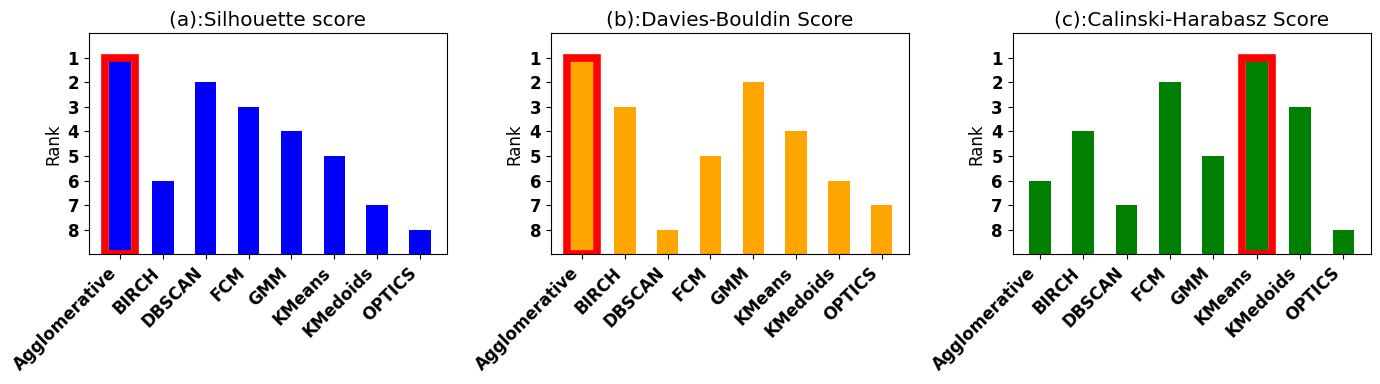

Parse input
     ... finished
Problem statistics
  3 votes
  8 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  28
    Took 0.000 secs
  # triangle constr:  336
    Took 0.000 secs
  Extended Condorcet reductions: 9 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.005 secs
Postprocessing
    ... finished
This is ["'Agglomerative'" "'FCM'" "'GMM'" "'KMeans'" "'BIRCH'" "'KMedoids'"
 "'DBSCAN'" "'OPTICS'"]
Agglomerative
['Agglomerative', 'FCM', 'GMM', 'KMeans', 'BIRCH', 'KMedoids', 'DBSCAN', 'OPTICS']
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 20 - 0.00 seconds
Cgl0004I processed model has 55 rows, 18 columns (18 integer (18 of which binary)) and 152 elements
Cbc0012I Integer solution of 20 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 20, took 0 iterat

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/661759729.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


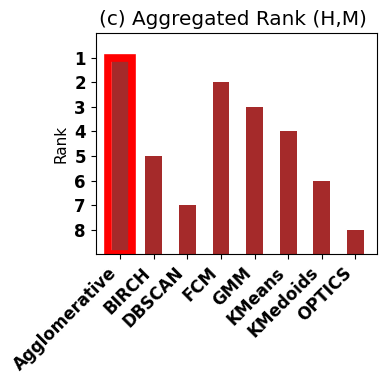

In [113]:
#-------------------------------------------------------------------------------
# ** generating HM-results (4) **
#-------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt


HM_Silhoute = KemenyRanking('HMresult_Silhouette.txt').get_solution()
HM_DaviesBouldin = KemenyRanking('HMresult_Davies-Bouldin.txt').get_solution()
HM_Calinski_Harabasz = KemenyRanking('HMresult_Calinski-Harabasz.txt').get_solution()


print("HM_DaviesBouldin:", HM_DaviesBouldin)
print("HM_Calinski_Harabasz:", HM_Calinski_Harabasz)
print("HM_Silhoute:", HM_Silhoute)

with open('HM_results.txt', 'w') as f:
    f.write("Sil: " + ' '.join(["'{}'".format(method) for method in HM_Silhoute]) + "\n")
    f.write("DB: " + ' '.join(["'{}'".format(method) for method in HM_DaviesBouldin]) + "\n")
    f.write("CH: " + ' '.join(["'{}'".format(method) for method in HM_Calinski_Harabasz]) + "\n")


def plot_rankings(ax, rank_list, title, color):
    rankings = {}
    for rank, method in enumerate(rank_list, 1):
        rankings[method] = rank

    df = pd.DataFrame({
        'Combined': pd.Series(rankings)
    })

    algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

    visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

    bars = ax.bar(visual_rank.index, visual_rank, color=color, width=0.5)
    highest_rank_bar = df['Combined'].idxmin()

    for bar in bars:
        if 9 - bar.get_height() == 1:
            rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
            ax.add_patch(rect)
            break

    ax.set_ylabel('Rank', fontsize=12)
    ax.set_ylim(0, 9)
    ax.set_yticks(range(1, 9))
    ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
    ax.set_title(title)
    ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
plot_rankings(ax1, HM_Silhoute, '(a):Silhouette score', 'blue')
plot_rankings(ax2, HM_DaviesBouldin, '(b):Davies-Bouldin Score', 'orange')
plot_rankings(ax3, HM_Calinski_Harabasz, '(c):Calinski-Harabasz Score', 'green')

plt.tight_layout()
plt.savefig('HMresults__evauation3.png', dpi=300)
plt.show()




HM_final2 = KemenyRanking('HM_results.txt').get_solution()

print("This is", HM_final2)
HM_final0 = ', '.join([method.strip('"') for method in HM_final2])



# Split the string using comma as a separator
split_list = HM_final0.split(', ')

# Now, remove the single quotes from each element of the list
HM_final = [name.strip("'") for name in split_list]

print(HM_final[0])


print(HM_final)

# Create a dataframe for plotting
rankings = {}
for rank, method in enumerate(HM_final, 1):
    rankings[method] = rank

df = pd.DataFrame({
    'Combined': pd.Series(rankings)
})

colors = {
    'Combined': 'brown'
}

algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Reduce the width for the figsize here
fig, ax = plt.subplots(figsize=(4, 4))

visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

bars = ax.bar(visual_rank.index, visual_rank, color=colors['Combined'], width=0.5)

highest_rank_bar = df['Combined'].idxmin()

# Highlight the highest rank bar with a red rectangle
for bar in bars:
    if 9 - bar.get_height() == 1:
        rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
        ax.add_patch(rect)
        break

ax.set_ylabel('Rank', fontsize=11)
ax.set_ylim(0, 9)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
ax.set_title('(c) Aggregated Rank (H,M) ')
ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('HMresults__aggregation3.png', dpi=300)
plt.show()



***Hresuts.xlsx (in 4 steps)***

In [99]:
#-------------------------------------------------------------------------------
# ** generating H-results (1) **
#-------------------------------------------------------------------------------
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, Birch
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


files_p = ["test_1_tuning.xlsx", "test_2_tuning.xlsx", "test_3_tuning.xlsx", "test_4_tuning.xlsx"]
#files_p = processing_procedure(files)
# EXCLUDE *******************************************************
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label' , 'MODULUS'] # please exclude those features that you dont need them
                                                                                           #First we do the expriments with Hardness alone and then Modulus Alone and then The combination of them
datasets = [pd.read_excel(file, engine='openpyxl').drop(columns_to_drop, axis=1, errors='ignore') for file in files_p]
scaled_datasets = [StandardScaler().fit_transform(df) for df in datasets]

clustering_algorithms = {
    'KMeans': KMeans(n_clusters=3, random_state=0 , init= 'k-means++' , n_init = 20 , max_iter = 100 ),

    'DBSCAN': DBSCAN(eps=0.2 , min_samples = 10),
    'Agglomerative': AgglomerativeClustering(n_clusters=3 , affinity = 'euclidean' ,  linkage = 'average'),
                     #linkage = {'ward' (default) , 'complete' , 'average' , 'single'}
                     #affinity= {'euclidean' , 'manhattan , 'cosine'}
    'OPTICS': OPTICS(min_samples = 3 , xi = 0.05),
    'KMedoids': KMedoids(n_clusters=3, random_state= 0 , init = 'random' , max_iter = 100),
                     #metric = {c , 'precomputed'}
    'GMM': GaussianMixture(n_components=3, max_iter=100 , covariance_type = 'tied'),
    'BIRCH': Birch(n_clusters=3 , branching_factor = 200 , threshold =0.1),

    'FCM': FCM(n_clusters=3 , m = 1.1)
}


metrics = {
    'Silhouette': silhouette_score,
    'Calinski-Harabasz': calinski_harabasz_score,
    'Davies-Bouldin': davies_bouldin_score
}

results = []

for index, (scaled_data, file_name) in enumerate(zip(scaled_datasets, files_p)):
    dataset_label = 'D' + str(index + 1)
    for algorithm_name, algorithm in clustering_algorithms.items():

        if algorithm_name == 'GMM':
            cluster_labels = algorithm.fit_predict(scaled_data)
        elif algorithm_name == 'FCM':
            algorithm.fit(scaled_data)
            cluster_labels = algorithm.u.argmax(axis=1)
        else:
            cluster_labels = algorithm.fit_predict(scaled_data)

        if len(set(cluster_labels)) > 1:
            for metric_name, metric_func in metrics.items():
                score = metric_func(scaled_data, cluster_labels)
                results.append({'Metric': metric_name,
                                'Dataset': dataset_label,
                                'Method': algorithm_name,
                                'Score': score})

results_df = pd.DataFrame(results)

# Reset the index to add 'Metric' and 'Dataset' as columns instead of multi-index
grouped = results_df.groupby(['Metric', 'Dataset', 'Method']).Score.mean().reset_index().pivot(index=['Metric', 'Dataset'], columns='Method', values='Score')
# Reset the multi-index and then set 'Dataset' as the new index
grouped = grouped.reset_index().set_index('Dataset')
grouped2 = grouped.reset_index().set_index('Metric')

if os.path.exists("H_results.xlsx"):
    os.remove("H_results.xlsx")

grouped.to_excel("H_results.xlsx")
print(grouped2.to_latex())




\begin{tabular}{llrrrrrrrr}
\toprule
Method & Dataset &  Agglomerative &        BIRCH &      DBSCAN &           FCM &           GMM &        KMeans &      KMedoids &     OPTICS \\
Metric            &         &                &              &             &               &               &               &               &            \\
\midrule
Calinski-Harabasz &      D1 &     556.925756 &  6870.196729 &   32.288542 &  17554.218254 &   6788.088192 &  17550.682046 &  16364.605607 &  14.316859 \\
Calinski-Harabasz &      D2 &     358.750778 &  3188.837682 &  242.546375 &  20575.461318 &  17086.979191 &  20575.343998 &  18548.078229 &  17.383679 \\
Calinski-Harabasz &      D3 &     178.638939 &  7491.833489 &  282.868131 &  23975.769164 &  22231.836816 &  23973.998863 &  21536.661352 &  19.431458 \\
Calinski-Harabasz &      D4 &    4890.695252 &  8029.446822 &  282.011739 &  16485.352598 &   6198.711516 &  16487.136700 &  14654.390029 &  21.083101 \\
Davies-Bouldin    &      D1 &       0.207

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/2116037698.py:80: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(grouped2.to_latex())


In [102]:


#-------------------------------------------------------------------------------
# ** generating H-results (2) **
#-------------------------------------------------------------------------------
import pandas as pd

# Step 1: Open the H_result.xlsx file
df = pd.read_excel("H_results.xlsx", engine='openpyxl')

# Clustering methods
clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Initialize an empty list to store rows and their corresponding rankings
interleaved_rows = []

for _, row in df.iterrows():
    # Append the original row first
    interleaved_rows.append(row)

    # Duplicate the row to assign rankings
    new_row = row.copy()
    new_row['Dataset'] = f"{row['Dataset']}_Ranking"

    # Depending on the metric, rank the clustering methods
    if row['Metric'] == 'Davies-Bouldin':
        rankings = row[clustering_methods].rank(ascending=True, method='first').astype(int)
    else:
        rankings = row[clustering_methods].rank(ascending=False, method='first').astype(int)

    new_row[clustering_methods] = rankings
    interleaved_rows.append(new_row)

# Convert the interleaved rows to a dataframe
rankings_df = pd.DataFrame(interleaved_rows)

# Save the updated results file
rankings_df.to_excel("H_results2.xlsx", index=False)






In [105]:

#-------------------------------------------------------------------------------
# ** generating H-results (3) **
#-------------------------------------------------------------------------------
import pandas as pd

results_df = pd.read_excel("H_results2.xlsx", engine='openpyxl')


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']


ranking_rows = results_df[results_df['Dataset'].str.contains('_Ranking', na=False)]

# Dictionary to store ordered methods for each metric
ordered_methods_dict = {}

for metric in ranking_rows['Metric'].unique():
    metric_subset = ranking_rows[ranking_rows['Metric'] == metric]

    # Extract ranking order for each Dataset within the metric
    for _, row in metric_subset.iterrows():

        # Order clustering methods by their rank
        ordered_methods = [clustering_methods[i] for i in row[clustering_methods].argsort()]


        if metric in ordered_methods_dict:
            ordered_methods_dict[metric].append({row['Dataset']: ordered_methods})
        else:
            ordered_methods_dict[metric] = [{row['Dataset']: ordered_methods}]

# Write to text files based on metric
for metric, datasets_order in ordered_methods_dict.items():
    with open(f"H_result_{metric}.txt", 'w') as f:
        for order in datasets_order:
            dataset_name = list(order.keys())[0]
            methods_order = ' '.join(order[dataset_name])
            f.write(f"{dataset_name}: {methods_order}\n")


# This give us an Aggregated_Ranking_Order across 4 datasets for each dataset /
# In the following we will plot the Barcharts based on the result of each Metrics



Parse input
     ... finished
Problem statistics
  4 votes
  8 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  28
    Took 0.000 secs
  # triangle constr:  336
    Took 0.000 secs
  Extended Condorcet reductions: 19 * 2 relations fixed
Solve: run MIP

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

  CoinOR CBC used 0.029 secs
Postprocessing
    ... finished
Parse input
command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 15 - 0.00 seconds
Cgl0004I processed model has 14 rows, 8 columns (8 integer (8 of which binary)) and 38 elements
Cbc0012I Integer solution of 15 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 15, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from 15 to 15
Probing was tried 0 times and created 0 cuts of

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/2916145502.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/2916145502.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/2916145502.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


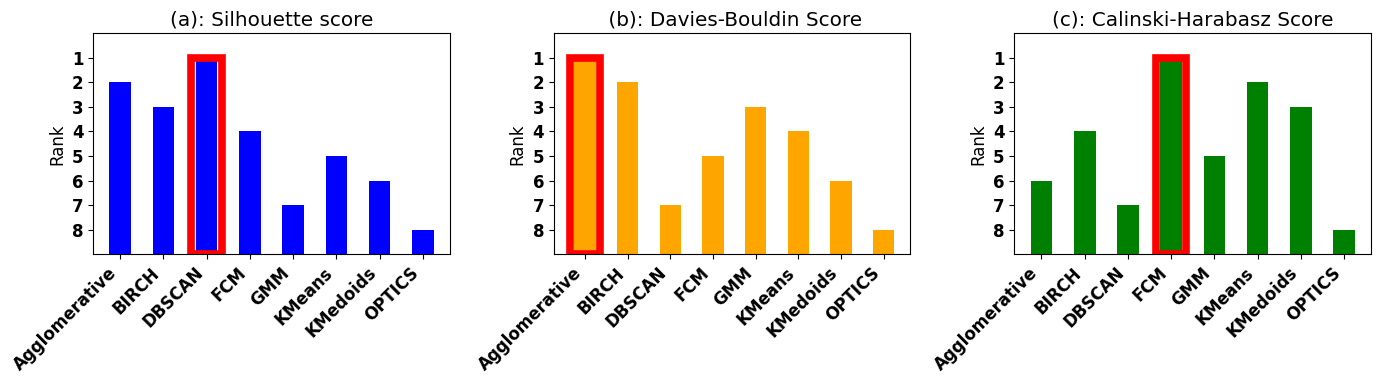

Parse input
     ... finished
Problem statistics
  3 votes
  8 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  28
    Took 0.000 secs
  # triangle constr:  336
    Took 0.000 secs
  Extended Condorcet reductions: 10 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.008 secs
Postprocessing
    ... finished
This is ["'Agglomerative'" "'BIRCH'" "'FCM'" "'KMeans'" "'KMedoids'" "'GMM'"
 "'DBSCAN'" "'OPTICS'"]
Agglomerative
This is H_final : 
  
['Agglomerative', 'BIRCH', 'FCM', 'KMeans', 'KMedoids', 'GMM', 'DBSCAN', 'OPTICS']
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 18 - 0.00 seconds
Cgl0004I processed model has 55 rows, 18 columns (18 integer (18 of which binary)) and 152 elements
Cbc0012I Integer solution of 18 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best obje

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/2916145502.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


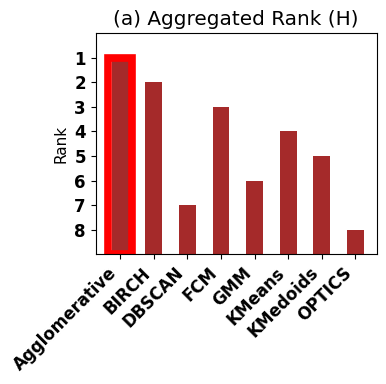

In [106]:

#-------------------------------------------------------------------------------
# ** generating H-results (4) **
#-------------------------------------------------------------------------------


import pandas as pd
import matplotlib.pyplot as plt


H_Silhoute = KemenyRanking('H_result_Silhouette.txt').get_solution()
H_DaviesBouldin = KemenyRanking('H_result_Davies-Bouldin.txt').get_solution()
H_Calinski_Harabasz = KemenyRanking('H_result_Calinski-Harabasz.txt').get_solution()


print("H_DaviesBouldin:", H_DaviesBouldin)
print("H_Calinski_Harabasz:", H_Calinski_Harabasz)
print("H_Silhoute:", H_Silhoute)

with open('H_results.txt', 'w') as f:
    f.write("Sil: " + ' '.join(["'{}'".format(method) for method in H_Silhoute]) + "\n")
    f.write("DB: " + ' '.join(["'{}'".format(method) for method in H_DaviesBouldin]) + "\n")
    f.write("CH: " + ' '.join(["'{}'".format(method) for method in H_Calinski_Harabasz]) + "\n")


def plot_rankings(ax, rank_list, title, color):
    rankings = {}
    for rank, method in enumerate(rank_list, 1):
        rankings[method] = rank

    df = pd.DataFrame({
        'Combined': pd.Series(rankings)
    })

    algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

    visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

    bars = ax.bar(visual_rank.index, visual_rank, color=color, width=0.5)
    highest_rank_bar = df['Combined'].idxmin()

    for bar in bars:
        if 9 - bar.get_height() == 1:
            rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
            ax.add_patch(rect)
            break

    ax.set_ylabel('Rank', fontsize=12)
    ax.set_ylim(0, 9)
    ax.set_yticks(range(1, 9))
    ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
    ax.set_title(title)
    ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
plot_rankings(ax1, H_Silhoute, '(a): Silhouette score', 'blue')
plot_rankings(ax2, H_DaviesBouldin,' (b): Davies-Bouldin Score', 'orange')
plot_rankings(ax3, H_Calinski_Harabasz, '(c): Calinski-Harabasz Score', 'green')

plt.tight_layout()
plt.savefig('Hresults__evauation3.png', dpi=300)
plt.show()




H_final2 = KemenyRanking('H_results.txt').get_solution()

print("This is", H_final2)
H_final0 = ', '.join([method.strip('"') for method in H_final2])



# Split the string using comma as a separator
split_list = H_final0.split(', ')

# Now, remove the single quotes from each element of the list
H_final = [name.strip("'") for name in split_list]

print(H_final[0])

print("This is H_final : \n  ")
print(H_final)

# Create a dataframe for plotting
rankings = {}
for rank, method in enumerate(H_final, 1):
    rankings[method] = rank

df = pd.DataFrame({
    'Combined': pd.Series(rankings)
})

colors = {
    'Combined': 'brown'
}

algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Reduce the width for the figsize here
fig, ax = plt.subplots(figsize=(4, 4))

visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

bars = ax.bar(visual_rank.index, visual_rank, color=colors['Combined'], width=0.5)

highest_rank_bar = df['Combined'].idxmin()

# Highlight the highest rank bar with a red rectangle
for bar in bars:
    if 9 - bar.get_height() == 1:
        rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
        ax.add_patch(rect)
        break

ax.set_ylabel('Rank', fontsize=11)
ax.set_ylim(0, 9)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
ax.set_title('(a) Aggregated Rank (H)')
ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Hresults__aggregation3.png', dpi=300)
plt.show()



Mresults.xlsx (in 4 steps)

In [103]:
#-------------------------------------------------------------------------------
# ** generating M-results (1) **
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, Birch
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


files_p = ["test_1_tuning.xlsx", "test_2_tuning.xlsx", "test_3_tuning.xlsx", "test_4_tuning.xlsx"]
#files_p = processing_procedure(files)
# EXCLUDE *******************************************************
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label' , 'HARDNESS'] # please exclude those features that you dont need them
                                                                                           #First we do the expriments with Hardness alone and then Modulus Alone and then The combination of them
datasets = [pd.read_excel(file, engine='openpyxl').drop(columns_to_drop, axis=1, errors='ignore') for file in files_p]
scaled_datasets = [StandardScaler().fit_transform(df) for df in datasets]

clustering_algorithms = {
    'KMeans': KMeans(n_clusters=3, random_state=0 , init= 'k-means++' , n_init = 20 , max_iter = 100 ),

    'DBSCAN': DBSCAN(eps=0.2 , min_samples = 10),
    'Agglomerative': AgglomerativeClustering(n_clusters=3 , affinity = 'euclidean' ,  linkage = 'average'),
                     #linkage = {'ward' (default) , 'complete' , 'average' , 'single'}
                     #affinity= {'euclidean' , 'manhattan , 'cosine'}
    'OPTICS': OPTICS(min_samples = 3 , xi = 0.05),
    'KMedoids': KMedoids(n_clusters=3, random_state= 0 , init = 'random' , max_iter = 100),
                     #metric = {c , 'precomputed'}
    'GMM': GaussianMixture(n_components=3, max_iter=100 , covariance_type = 'tied'),
    'BIRCH': Birch(n_clusters=3 , branching_factor = 200 , threshold =0.1),

    'FCM': FCM(n_clusters=3 , m = 1.1)
}


metrics = {
    'Silhouette': silhouette_score,
    'Calinski-Harabasz': calinski_harabasz_score,
    'Davies-Bouldin': davies_bouldin_score
}

results = []

for index, (scaled_data, file_name) in enumerate(zip(scaled_datasets, files_p)):
    dataset_label = 'D' + str(index + 1)
    for algorithm_name, algorithm in clustering_algorithms.items():

        if algorithm_name == 'GMM':
            cluster_labels = algorithm.fit_predict(scaled_data)
        elif algorithm_name == 'FCM':
            algorithm.fit(scaled_data)
            cluster_labels = algorithm.u.argmax(axis=1)
        else:
            cluster_labels = algorithm.fit_predict(scaled_data)

        if len(set(cluster_labels)) > 1:
            for metric_name, metric_func in metrics.items():
                score = metric_func(scaled_data, cluster_labels)
                results.append({'Metric': metric_name,
                                'Dataset': dataset_label,
                                'Method': algorithm_name,
                                'Score': score})

results_df = pd.DataFrame(results)

# Reset the index to add 'Metric' and 'Dataset' as columns instead of multi-index
grouped = results_df.groupby(['Metric', 'Dataset', 'Method']).Score.mean().reset_index().pivot(index=['Metric', 'Dataset'], columns='Method', values='Score')
# Reset the multi-index and then set 'Dataset' as the new index
grouped = grouped.reset_index().set_index('Dataset')

if os.path.exists("M_results.xlsx"):
    os.remove("M_results.xlsx")

grouped.to_excel("M_results.xlsx")
print(grouped.to_latex())


\begin{tabular}{llrrrrrrrr}
\toprule
Method &             Metric &  Agglomerative &         BIRCH &      DBSCAN &           FCM &           GMM &        KMeans &      KMedoids &     OPTICS \\
Dataset &                    &                &               &             &               &               &               &               &            \\
\midrule
D1      &  Calinski-Harabasz &     231.092640 &   9258.034544 &  182.109926 &  18366.779761 &   2974.769829 &  18366.909188 &  17093.305011 &  17.736525 \\
D2      &  Calinski-Harabasz &     311.672440 &   2170.389714 &   20.903852 &  15871.237971 &   2645.466439 &  15871.196172 &  14792.024857 &  19.813960 \\
D3      &  Calinski-Harabasz &     601.678079 &  14196.037240 &   59.481555 &  22988.183575 &  10892.875732 &  22982.925722 &  22146.063254 &  23.161699 \\
D4      &  Calinski-Harabasz &    2614.386480 &   2694.157375 &  815.248058 &  14909.109533 &  14414.622808 &  14908.680169 &  12587.837437 &  22.319200 \\
D1      &     Davie

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/823161265.py:80: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(grouped.to_latex())


In [108]:
#-------------------------------------------------------------------------------
# ** generating M-results (2) **
#-------------------------------------------------------------------------------
import pandas as pd

# Step 1: Open the HMresult.xlsx file
df = pd.read_excel("M_results.xlsx", engine='openpyxl')

# Clustering methods
clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Initialize an empty list to store rows and their corresponding rankings
interleaved_rows = []

for _, row in df.iterrows():
    # Append the original row first
    interleaved_rows.append(row)

    # Duplicate the row to assign rankings
    new_row = row.copy()
    new_row['Dataset'] = f"{row['Dataset']}_Ranking"

    # Depending on the metric, rank the clustering methods
    if row['Metric'] == 'Davies-Bouldin':
        rankings = row[clustering_methods].rank(ascending=True, method='first').astype(int)
    else:
        rankings = row[clustering_methods].rank(ascending=False, method='first').astype(int)

    new_row[clustering_methods] = rankings
    interleaved_rows.append(new_row)

# Convert the interleaved rows to a dataframe
rankings_df = pd.DataFrame(interleaved_rows)

# Save the updated results file
rankings_df.to_excel("M_results2.xlsx", index=False)




In [109]:
#-------------------------------------------------------------------------------
# ** generating M-results (3) **
#-------------------------------------------------------------------------------

import pandas as pd

results_df = pd.read_excel("M_results2.xlsx", engine='openpyxl')


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']


ranking_rows = results_df[results_df['Dataset'].str.contains('_Ranking', na=False)]

# Dictionary to store ordered methods for each metric
ordered_methods_dict = {}

for metric in ranking_rows['Metric'].unique():
    metric_subset = ranking_rows[ranking_rows['Metric'] == metric]

    # Extract ranking order for each Dataset within the metric
    for _, row in metric_subset.iterrows():

        # Order clustering methods by their rank
        ordered_methods = [clustering_methods[i] for i in row[clustering_methods].argsort()]


        if metric in ordered_methods_dict:
            ordered_methods_dict[metric].append({row['Dataset']: ordered_methods})
        else:
            ordered_methods_dict[metric] = [{row['Dataset']: ordered_methods}]

# Write to text files based on metric
for metric, datasets_order in ordered_methods_dict.items():
    with open(f"M_result_{metric}.txt", 'w') as f:
        for order in datasets_order:
            dataset_name = list(order.keys())[0]
            methods_order = ' '.join(order[dataset_name])
            f.write(f"{dataset_name}: {methods_order}\n")


# This give us an Aggregated_Ranking_Order across 4 datasets for each dataset /
# In the following we will plot the Barcharts based on the result of each Metrics

Parse input
     ... finished
Problem statistics
  4 votes
  8 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  28
    Took 0.000 secs
  # triangle constr:  336
    Took 0.000 secs
  Extended Condorcet reductions: 19 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.006 secs
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Postprocessing
    ... finished
Parse input
Continuous objective value is 16 - 0.00 seconds
Cgl0004I processed model has 14 rows, 8 columns (8 integer (8 of which binary)) and 38 elements
Cbc0012I Integer solution of 16 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 16, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from 16 to 16
Probing was tried 0 times and created 0 cuts of

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/532506769.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/532506769.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/532506769.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


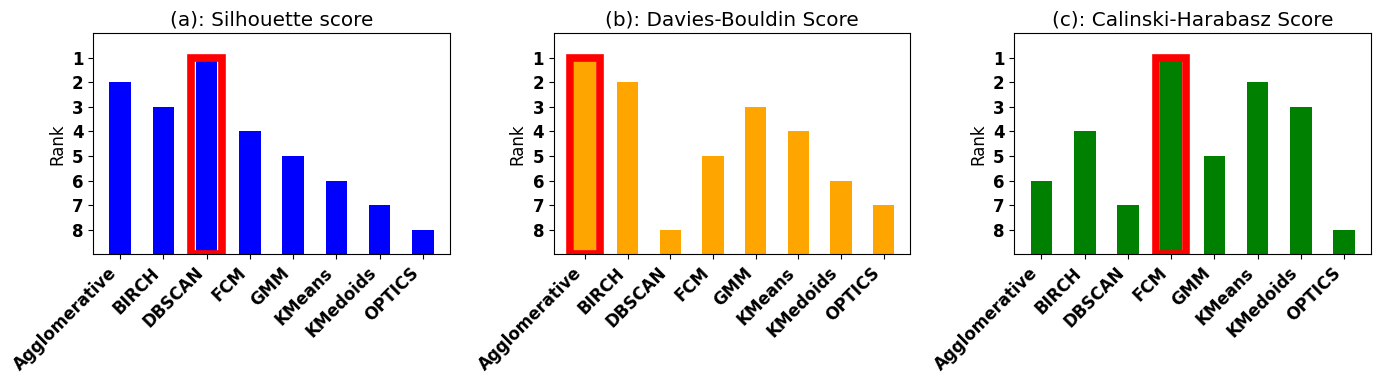

Parse input
     ... finished
Problem statistics
  3 votes
  8 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  28
    Took 0.000 secs
  # triangle constr:  336
    Took 0.000 secs
  Extended Condorcet reductions: 9 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.005 secs
Postprocessing
    ... finished
This is ["'Agglomerative'" "'BIRCH'" "'FCM'" "'GMM'" "'KMeans'" "'KMedoids'"
 "'DBSCAN'" "'OPTICS'"]
Agglomerative
['Agglomerative', 'BIRCH', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'DBSCAN', 'OPTICS']
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 19 - 0.00 seconds
Cgl0004I processed model has 55 rows, 18 columns (18 integer (18 of which binary)) and 152 elements
Cbc0012I Integer solution of 19 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 19, took 0 iterat

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/532506769.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


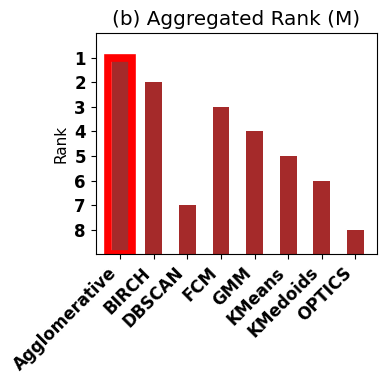

In [110]:
#-------------------------------------------------------------------------------
# ** generating M-results (4) **
#-------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt


M_Silhoute = KemenyRanking('M_result_Silhouette.txt').get_solution()
M_DaviesBouldin = KemenyRanking('M_result_Davies-Bouldin.txt').get_solution()
M_Calinski_Harabasz = KemenyRanking('M_result_Calinski-Harabasz.txt').get_solution()


print("M_DaviesBouldin:", M_DaviesBouldin)
print("M_Calinski_Harabasz:", M_Calinski_Harabasz)
print("M_Silhoute:", M_Silhoute)

with open('M_results.txt', 'w') as f:
    f.write("Sil: " + ' '.join(["'{}'".format(method) for method in M_Silhoute]) + "\n")
    f.write("DB: " + ' '.join(["'{}'".format(method) for method in M_DaviesBouldin]) + "\n")
    f.write("CH: " + ' '.join(["'{}'".format(method) for method in M_Calinski_Harabasz]) + "\n")


def plot_rankings(ax, rank_list, title, color):
    rankings = {}
    for rank, method in enumerate(rank_list, 1):
        rankings[method] = rank

    df = pd.DataFrame({
        'Combined': pd.Series(rankings)
    })

    algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

    visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

    bars = ax.bar(visual_rank.index, visual_rank, color=color, width=0.5)
    highest_rank_bar = df['Combined'].idxmin()

    for bar in bars:
        if 9 - bar.get_height() == 1:
            rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
            ax.add_patch(rect)
            break

    ax.set_ylabel('Rank', fontsize=12)
    ax.set_ylim(0, 9)
    ax.set_yticks(range(1, 9))
    ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
    ax.set_title(title)
    ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
plot_rankings(ax1, M_Silhoute, '(a): Silhouette score', 'blue')
plot_rankings(ax2, M_DaviesBouldin, '(b): Davies-Bouldin Score', 'orange')
plot_rankings(ax3, M_Calinski_Harabasz, '(c): Calinski-Harabasz Score', 'green')

plt.tight_layout()
plt.savefig('Mresults__evauation3.png', dpi=300)
plt.show()




M_final2 = KemenyRanking('M_results.txt').get_solution()

print("This is", M_final2)
M_final0 = ', '.join([method.strip('"') for method in M_final2])



# Split the string using comma as a separator
split_list = M_final0.split(', ')

# Now, remove the single quotes from each element of the list
M_final = [name.strip("'") for name in split_list]

print(M_final[0])


print(M_final)

# Create a dataframe for plotting
rankings = {}
for rank, method in enumerate(M_final, 1):
    rankings[method] = rank

df = pd.DataFrame({
    'Combined': pd.Series(rankings)
})

colors = {
    'Combined': 'brown'
}

algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Reduce the width for the figsize here
fig, ax = plt.subplots(figsize=(4, 4))

visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

bars = ax.bar(visual_rank.index, visual_rank, color=colors['Combined'], width=0.5)

highest_rank_bar = df['Combined'].idxmin()

# Highlight the highest rank bar with a red rectangle
for bar in bars:
    if 9 - bar.get_height() == 1:
        rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
        ax.add_patch(rect)
        break

ax.set_ylabel('Rank', fontsize=11)
ax.set_ylim(0, 9)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
ax.set_title('(b) Aggregated Rank (M)')
ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Mresults__aggregation3.png', dpi=300)
plt.show()


Kenemy Method for Aggregation

Parse input
     ... finished
Problem statistics
  3 votes
  8 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  28
    Took 0.000 secs
  # triangle constr:  336
    Took 0.000 secs
  Extended Condorcet reductions: 23 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.003 secs
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Postprocessing
    ... finished
Final_result :  ['Agglomerative', 'BIRCH', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'DBSCAN', 'OPTICS']
Ranked Methods Dict: {'Agglomerative': 1, 'BIRCH': 2, 'FCM': 3, 'GMM': 4, 'KMeans': 5, 'KMedoids': 6, 'DBSCAN': 7, 'OPTICS': 8}
Continuous objective value is 5 - 0.00 seconds
Cgl0004I processed model has 4 rows, 4 columns (4 integer (4 of which binary)) and 10 elements
Cbc0012I Integer solution of 5 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best obje

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_6126/3436972613.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


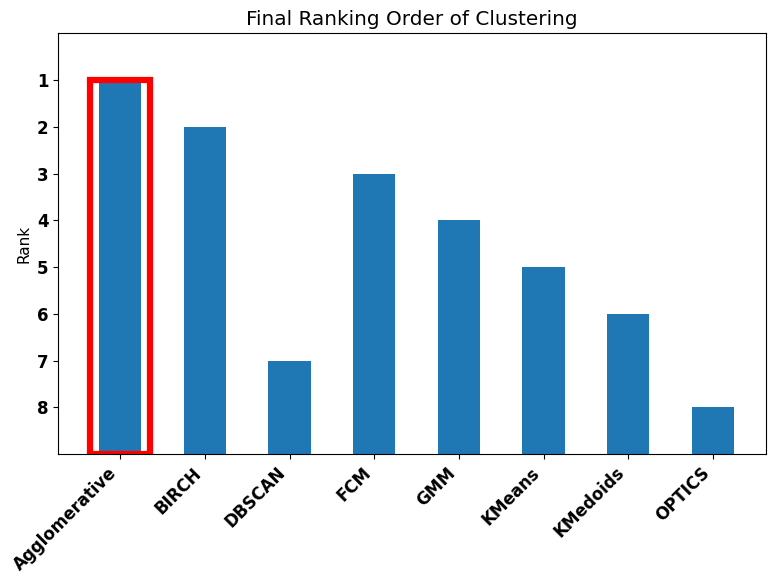

In [115]:
#---------------------------------------------------------
#------------FINAL RESULT OF THE EXPRIMENT----------------
#--------------FINAL RANKING WITH KEMENY------------------
#----------------------------------------------------------


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Writing data to the aggregated results file in txt file for kenemy method:
with open("final_final_aggregated.txt", "w") as file:
    file.write("M_final: " + ", ".join(map(str, M_final)) + "\n")
    file.write("H_final: " + ", ".join(map(str, H_final)) + "\n")
    file.write("HM_final: " + ", ".join(map(str, HM_final)) + "\n")


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']    

# Get final results from Kemeny ranking
final_results = KemenyRanking("final_final_aggregated.txt").get_solution() 
final_results = [algorithm.replace(',', '') for algorithm in final_results]
print("Final_result : " , final_results)


ranked_methods_dict = {method: rank for rank, method in enumerate(final_results, 1)}
print("Ranked Methods Dict:", ranked_methods_dict)

fig, ax = plt.subplots(figsize=(8, 6))


visual_rank = 9 - pd.Series(ranked_methods_dict).reindex(clustering_methods).fillna(9)

bars = ax.bar(visual_rank.index, visual_rank, width=0.5)


highest_rank_method = max(ranked_methods_dict, key=ranked_methods_dict.get)


for bar in bars:
    if bar.get_height() == 8:  # Because rank 1 visually appears as height 8
        rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=4.5)
        ax.add_patch(rect)
        break

ax.set_ylabel('Rank', fontsize=11)
ax.set_ylim(0, 9)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
ax.set_title('Final Ranking Order of Clustering')
ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('final_results_evaluation.png', dpi=300)
plt.show()